In [41]:
from torchvision import models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
import numpy as np


In [42]:

def objectpre(image, nc=21):
  
  colors = np.array([(0, 0, 0),            
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
             
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
             (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
              (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = colors[l, 0]
    g[idx] = colors[l, 1]
    b[idx] = colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [43]:
def objectdection(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
 
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

  rgb = objectpre(om)
  
  
  return rgb

In [44]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

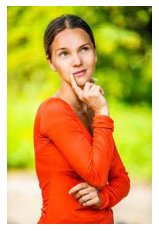

In [45]:
rgb=objectdection(dlab, '/content/pic.jpg')

In [48]:
def backgroundremoval(rgb,source):
  import cv2
  
  foreground = cv2.imread(source)


  
 
  foreground = cv2.resize(foreground,(rgb.shape[1],rgb.shape[0]))
  cv2.imwrite('aa1.png',foreground)

  background = 255 * np.ones_like(rgb).astype(np.uint8)

  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)
  #mask3 = np.zeros_like(rgb)
  #mask3 = np.repeat(mask3[:, :, np.newaxis], 3, axis=2)
  
 # mask4 = cv2.GaussianBlur(mask3, (3, 3), 0)
  #alpha1 = mask4.astype(float) * 1.1  # making blend stronger
  #cv2.imwrite('aa5.png',alpha1)



  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)
  cv2.imwrite('aa5.png',alpha)

  alpha = cv2.GaussianBlur(alpha, (7,7),0)

  alpha = alpha.astype(float)/255

  
  foreground = cv2.multiply(alpha, foreground)

  cv2.imwrite('output.png',foreground)

 
  background = cv2.multiply(1.0 - alpha, background)
  cv2.imwrite('object.png',background)

  outImage = cv2.add(foreground, background)

  

In [49]:
backgroundremoval(rgb,'/content/pic.jpg')
